In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
news_scores = { 
    "dutch" : {
        'Telegraaf' : 3.6,
        'Geenstijl' : 3.6,
        'RTL' : 3.4,
        'NOS' : 3.3,
        'NU.nl' : 3.3,
        'AD' : 3.4,
        'Volkskrant' : 2.9
    },

    "german" : {
        'Bild' : 3.1,
        'FAZ' : 2.9,
        'RTL' : 3.0,
        'Sat1' : 3.0,
        'Sz' : 2.8,
        'ARD' : 2.9,
        'Der Spiegel' : 2.8
    },   
    "french" : {
        'TF1' : 3.3,
        'Le Figaro' : 3.3,
        'BFM' : 3.2,
        "L'Express" : 2.9,
        'Le Monde' : 2.9,
        'France 2' : 3.1,
        'Libération' : 2.5,
        'Mediapart' : 2.4
    }
}


In [4]:
news_scores = {'dutch': {
    'Telegraaf': 1.0,
    'Geenstijl': 1.0,
    'RTL': 0.6666666666666665,
    'NOS': 0.49999999999999956,
    'NU.nl': 0.49999999999999956,
    'AD': 0.6666666666666665,
    'Volkskrant': -0.16666666666666674,
    }, 'german': {
    'Bild': 0.16666666666666674,
    'FAZ': -0.16666666666666674,
    'RTL': 0.0,
    'Sat1': 0.0,
    'Sz': -0.3333333333333336,
    'ARD': -0.16666666666666674,
    'Der Spiegel': -0.3333333333333336,
    }, 'french': {
    'TF1': 0.49999999999999956,
    'Le Figaro': 0.49999999999999956,
    'BFM': 0.3333333333333335,
    "L'Express": -0.16666666666666674,
    'Le Monde': -0.16666666666666674,
    'France 2': 0.16666666666666674,
    'Lib\xc3\xa9ration': -0.8333333333333333,
    'Mediapart': -1.0,
    }}


In [5]:
# normalizer

all_scores = []
for language in news_scores.values():
    all_scores.extend(language.values())
# Step 2: Calculate the overall min and max values
min_score = min(all_scores)
max_score = max(all_scores)
# Step 3: Normalize the scores to the range [-1, 1]
normalized_scores = {}
for language, sites in news_scores.items():
    normalized_scores[language] = {
        site: (2 * (score - min_score) / (max_score - min_score)) - 1
        for site, score in sites.items()
    }
# Print the normalized scores
print(normalized_scores)

{'dutch': {'Telegraaf': 1.0, 'Geenstijl': 1.0, 'RTL': 0.6666666666666665, 'NOS': 0.49999999999999956, 'NU.nl': 0.49999999999999956, 'AD': 0.6666666666666665, 'Volkskrant': -0.16666666666666674}, 'german': {'Bild': 0.16666666666666674, 'FAZ': -0.16666666666666674, 'RTL': 0.0, 'Sat1': 0.0, 'Sz': -0.3333333333333336, 'ARD': -0.16666666666666674, 'Der Spiegel': -0.3333333333333336}, 'french': {'TF1': 0.49999999999999956, 'Le Figaro': 0.49999999999999956, 'BFM': 0.3333333333333335, "L'Express": -0.16666666666666674, 'Le Monde': -0.16666666666666674, 'France 2': 0.16666666666666674, 'LibÃ©ration': -0.8333333333333333, 'Mediapart': -1.0}}


In [6]:
scores_per_place = {1 : 2,
                    2 : 1.75,
                    3 : 1.5,
                    4 : 1.25,
                    5 : 1
                    }

In [8]:
def process_score(row, start, xend, language):
    scores = news_scores[language]
    score = 0
    for site in row.index[start+1:xend+1]:
        # print(site)
        site_stripped = site[:-2] 
        site_place = row[site] 
        if pd.notna(site_place):
            if isinstance(site_place, str):
                if ',' in site_place :
                    splitted = site_place.split(',')
                    for spl in splitted:
                        score += scores_per_place[int(spl)] * scores[site_stripped]
                else: 
                    site_place = int(site_place)
                    score += scores_per_place[site_place] * scores[site_stripped]
            else:
                score += scores_per_place[site_place] * scores[site_stripped]
    return score

In [9]:
def compute_scores(df, lang):
    # compute score per query
    df['score-c'] = df.apply(
            lambda row: process_score(row, 0, 7, lang), axis=1
        )
    df['score-d'] = df.apply(
            lambda row: process_score(row, 7, 14, lang), axis=1
        )
    df['score-g'] = df.apply(
            lambda row: process_score(row, 14, 21, lang), axis=1
        )

    # compute avg
    # Replace 0 with NaN for specific columns
    cols_to_average = ['score-c', 'score-d', 'score-g']
    df[cols_to_average] = df[cols_to_average].replace(0, pd.NA)
    df['score-avg'] = df[cols_to_average].mean(axis=1)
    return df

In [10]:
def plot_avg(df):

    plt.figure(figsize=(8, 4))
    plt.scatter(df['score-avg'], [0] * len(df), color='b', alpha=0.7)
    sns.boxplot(x=df['score-avg'], color='skyblue', zorder=1)
    plt.scatter(df['score-avg'], [0] * len(df), color='b', alpha=0.7, s=50, zorder=2)

    offset = 0.007  # Offset value to prevent overlap
    for i, value in enumerate(df['score-avg']):
        # Adjust the y position slightly for each label to avoid overlap
        plt.text(value, (-offset * (i + 1)) -0.04, str(df['Participant'].iloc[i]), 
                horizontalalignment='center', verticalalignment='top', 
                color='black', size=8)
        
    plt.xlabel('Score Average')
    plt.title('Boxplot of Score Averages')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

In [20]:
file_path_dutch = "IR_data_Dutch.csv"
file_path_german = "IR_data_German.csv"
dutch_df = pd.read_csv(file_path_dutch)
german_df = pd.read_csv(file_path_german)
# dutch_df = dutch_df.fillna(0)
# print(dutch_df)

dutch_df_extended = compute_scores(dutch_df, 'dutch')
german_df_extended = compute_scores(german_df, 'german')

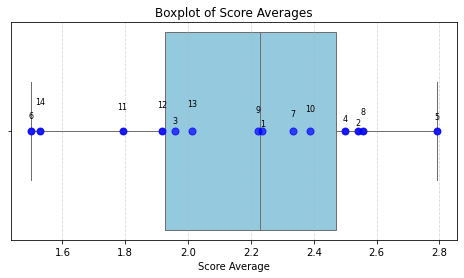

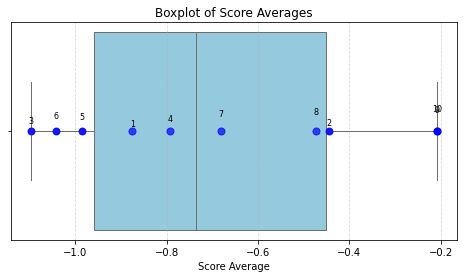

In [21]:
plot_avg(dutch_df_extended)
plot_avg(german_df_extended)

for every participant avg score
first per query (weighted score)
then avg of 3 query 
weights 



In [261]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Disable line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content in each column

german_df

,Participant,Bild-c,FAZ-c,RTL-c,Sat1-c,Sz-c,ARD-c,Der Spiegel-c,Bild-d,FAZ-d,RTL-d,Sat1-d,Sz-d,ARD-d,Der Spiegel-d,Bild-g,FAZ-g,RTL-g,Sat1-g,Sz--g,ARD-g,Der Spiegel-g,Age,Gender,Nationality,Location,score-c,score-d,score-g,score-avg
0,1,NaN,NaN,NaN,NaN,2.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,4,NaN,NaN,NaN,NaN,2.0,22,f,German,Regensburg,-1.250000,-0.583333,-0.791667,-0.875000
1,2,1.0,NaN,NaN,NaN,NaN,"3,5",NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,3.0,27,m,German,Freiburg,-0.083333,-0.541667,-0.708333,-0.444444
2,3,NaN,NaN,NaN,NaN,2.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,"2,5",NaN,"3,4",NaN,NaN,NaN,NaN,1.0,24,f,German,Dusseldorf,-1.250000,-0.916667,-1.125,-1.097222
3,4,2.0,NaN,NaN,NaN,NaN,"3,5",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,m,German,Nijmegen,-0.791667,<NA>,<NA>,-0.791667
4,5,NaN,NaN,NaN,NaN,2.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,"3,4",NaN,NaN,NaN,NaN,1.0,20,f,German,Nuremberg,-1.250000,-0.583333,-1.125,-0.986111
5,6,NaN,NaN,NaN,NaN,3.0,NaN,"1,2",NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,4,NaN,NaN,NaN,NaN,1.0,22,f,German,Nuremberg,-1.750000,-0.5,-0.875,-1.041667
6,7,3.0,NaN,NaN,NaN,NaN,4,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,3,NaN,NaN,NaN,NaN,1.0,24,f,German,Phuket,-0.625000,-0.5,-0.916667,-0.680556
7,8,NaN,NaN,NaN,NaN,NaN,NaN,"4,5",NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,5.0,22,f,German,Nuremberg,-0.750000,-0.333333,-0.333333,-0.472222
8,9,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,f,German,Wellington,-0.208333,<NA>,<NA>,-0.208333
9,10,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,m,German,Wellington,-0.208333,<NA>,<NA>,-0.208333
